In [1]:
## packages
# coding: utf-8
import os
import random
import numpy as np
import pandas as pd
import json
import copy
from collections import defaultdict
from collections import Counter

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model


from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, Model, load_model
from keras.layers import multiply,Flatten,Permute,Embedding, Dense, Input, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, Layer, LSTM, Bidirectional, Average, concatenate
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import precision_score, recall_score,accuracy_score,confusion_matrix

#from attention_utils import get_activations, get_data

#from LSTM.NonMasking import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [3]:
random.seed(10)

In [4]:
ori_data = pd.read_csv("/Users/lina/desktop/CAPSTONE/final_result.csv")

In [5]:
# construcrt disease dict
count=0
disease_set=set(ori_data.PBSDISEASEGROUP)
disease_dict = {}
for item in disease_set:
    count += 1
    disease_dict[item]=count
 
print("this is diease_dict: ")
print(disease_dict)



this is diease_dict: 
{'Nocturnal enuresis': 1, 'Cardiac transplant': 2, 'Functional carcinoid tumour': 3, 'To reduce drive in sexual deviations in males': 4, 'Maple syrup urine disease': 5, 'Septicaemia': 6, 'Pancreatic neuroendocrine tumour (pNET)': 7, 'Gram-positive coccal infections': 8, 'Faecal impaction': 9, 'Hypsarrhythmia and/or infantile spasms': 10, 'Pseudomembranous colitis': 11, 'Hodgkin': 12, 'Thrombocytopenia': 13, 'Psoriasis': 14, 'Chronic obstructive pulmonary disease (COPD)': 15, 'Chronic gout': 16, 'Congenital abnormalities': 17, 'Keratitis': 18, 'Breast disease': 19, 'Germ cell tumour': 20, 'Endocarditis': 21, 'Short stature': 22, 'Staph infections': 23, 'Dietary management': 24, 'Hyperphenylalaninemia': 25, 'Gastrointestinal stromal tumour': 26, 'Colorectal Cancer': 27, 'Lipoatrophy': 28, 'Coronary artery disease': 29, 'Pyruvate dehydrogenase deficiency': 30, 'Ulcer': 31, 'Familial hypophosphataemia': 32, 'Acute allergic reaction with anaphylaxis': 33, 'Zollinger-El

In [6]:
# patients history dict
count =0
patient_id=""
disease_list=[]
patient_history_dict=defaultdict(list)

for obj in ori_data.itertuples(index=True, name='Pandas'):
    patient_history_dict[obj.MASTERPATIENTID].append(disease_dict[obj.PBSDISEASEGROUP])
    count +=1
   
       
#print(info_collection)   

# preprocess data
* a single history sequence without repilicated medicien for a patient
* several sequence  for a patient



### a single history sequence without repilicated medicien for a patient -- dict


In [7]:
# a single sequence without repilicated medicien for a patient

no_repeat_history_dict=defaultdict(list)

i =0
for pa_id in patient_history_dict:
    for med in patient_history_dict.get(pa_id):
        if med not in no_repeat_history_dict[pa_id]:
            no_repeat_history_dict[pa_id].append(med)
   
print("size of no_repeat_history_dict: ",len(no_repeat_history_dict))
for pa_id in no_repeat_history_dict:
    print (pa_id, no_repeat_history_dict.get(pa_id))
    break

size of no_repeat_history_dict:  258252
de4f47f37b5e7087177225b35784163011664547_2 [154, 277, 189, 266, 276, 272, 195, 109, 268, 145, 249, 213, 65, 262, 78, 34, 171, 279]


### several history sequences for a patient -- 3D list
* each patient
* each sublist
* each medicien


In [8]:
# read the top 50 list
import csv
top5_list = []
with open("/Users/lina/desktop/CAPSTONE/Top50.csv") as csvfile:
    csv_reader = csv.reader(csvfile)  # 使用csv.reader读取csvfile中的文件
    header = next(csv_reader)  # 读取第一行每一列的标题
    for row in csv_reader:
        top5_list.append(disease_dict[row[0]])
print(top5_list)
print(len(top5_list))

[39, 9, 233, 45, 262, 276, 145, 58, 31, 23, 65, 86, 154, 272, 171, 149, 213, 293, 195, 268, 249, 109, 74, 242, 102, 15, 264, 143, 108, 34, 251, 265, 158, 98, 119, 44, 93, 36, 189, 266, 277, 185, 231, 253, 128, 78, 76, 187, 246, 8]
50


In [10]:
# construcrt top50 dict
count=0
top50_dict = {}
for item in top5_list:
    count += 1
    top50_dict[item]=count
 
print("this is top50_dict: ")
print(top50_dict)

this is top50_dict: 
{39: 1, 9: 2, 233: 3, 45: 4, 262: 5, 276: 6, 145: 7, 58: 8, 31: 9, 23: 10, 65: 11, 86: 12, 154: 13, 272: 14, 171: 15, 149: 16, 213: 17, 293: 18, 195: 19, 268: 20, 249: 21, 109: 22, 74: 23, 242: 24, 102: 25, 15: 26, 264: 27, 143: 28, 108: 29, 34: 30, 251: 31, 265: 32, 158: 33, 98: 34, 119: 35, 44: 36, 93: 37, 36: 38, 189: 39, 266: 40, 277: 41, 185: 42, 231: 43, 253: 44, 128: 45, 78: 46, 76: 47, 187: 48, 246: 49, 8: 50}


In [11]:
# modify the last position of medicien in top50_dict
i =0
complete_list_new=[]
for pa_id in no_repeat_history_dict:
    temp_list_pa_id =[]# patient
    temp_sublist =[] #item
    history = no_repeat_history_dict.get(pa_id)
    if history[-1] in top5_list:
        history[-1] = top50_dict.get(history[-1])
        temp_list_pa_id.append(history)
        complete_list_new.append(temp_list_pa_id)
    
    i+=1
    if i == 10:
        print(complete_list_new)


        
print(len(complete_list_new))
    

[[[65, 276, 31]], [[145, 293, 149, 213, 24, 52, 106, 23, 167, 233, 39, 9, 242, 74, 135, 31, 102, 206, 246, 272, 224, 262, 34, 171, 6]], [[74, 154, 264, 207, 68, 246, 36]], [[102, 58, 208, 171, 266, 189, 277, 36, 93, 262, 34, 272, 143, 145, 65, 98, 15, 45, 185, 231, 265, 10]], [[31, 213, 34, 171, 272, 5]], [[213, 78, 276, 14]], [[171, 277, 266, 189, 102, 149, 293, 14, 262, 154, 200, 145, 276, 86, 119, 65, 15, 35, 58, 224, 104, 246, 110, 272, 9]], [[273, 51, 205, 272, 128, 265, 157, 266, 189, 277, 6]]]
215424


## trainning data

In [62]:
# set time stemps
time_stamps = 20


In [43]:
# for multi-classification

record_len_x =[]
def modify_XY(history_list, time_stamps):
    sample_x=[]
    sample_y=[]
    for pa_id in history_list:
        for med_history in pa_id:
            if len(med_history)>2:
                record_len_x.append(len(med_history)-1)
                sample_x.append(med_history[0:-1])
                sample_y.append(med_history[-1])
            

    sample_x = pad_sequences(sample_x, time_stamps)
    
    state = np.random.get_state()
    np.random.shuffle(sample_x)
    np.random.set_state(state)
    np.random.shuffle(sample_y)
    np.random.set_state(state)
    np.random.shuffle(record_len_x)


    return sample_x, sample_y,record_len_x
 


In [69]:
# for binary classification

def modify_XY_binary(history_list, time_stamps,target):
    record_len_x =[]
    sample_x0=[]
    sample_x1=[]
    sample_y=[]
    for pa_id in history_list:
        for med_history in pa_id:
            if len(med_history)>2:
                record_len_x.append(len(med_history)-1)
                if med_history[-1] == target:
                    sample_x1.append(med_history[0:-1])
                else:
                    if target not in med_history[0:-1]:
                        sample_x0.append(med_history[0:-1])
    
                          

    sample_x0 = pad_sequences(sample_x0, time_stamps)
    sample_x1 = pad_sequences(sample_x1, time_stamps)
    
    state = np.random.get_state()
    np.random.shuffle(sample_x0)
    state = np.random.get_state()
    np.random.shuffle(sample_x1)
    print(len(sample_x0),len(sample_x1))
    
    sample_x = list(sample_x1)
    for i in range(len(sample_x1)):
        sample_x.append(sample_x0[i])
    
    #print("sample_x",len(sample_x))
    sample_y = [1 for i in range(len(sample_x1))]+[0 for i in range(len(sample_x1))]
    print(len(sample_x),len(sample_y))
    
    np.random.set_state(state)
    np.random.shuffle(sample_y)
    np.random.set_state(state)
    np.random.shuffle(sample_x)


    return sample_x, sample_y,record_len_x
 

In [18]:
def one_hot_code(x_list,y_list,refer_dict_x,refer_dict_y):
    embedding_dim_x = len(refer_dict_x)+1 # index from 1
    embedding_dim_y = len(refer_dict_y)+1 # index from 1
    encoded_X = to_categorical(x_list,embedding_dim_x)
    encoded_Y = to_categorical(y_list,embedding_dim_y)
    print("one_hot_code: ",encoded_X.shape,encoded_Y.shape)    
    return encoded_X,encoded_Y

In [76]:
def one_hot_code_binary(x_list,y_list,refer_dict_x):
    embedding_dim_x = len(refer_dict_x)+1 # index from 1
    encoded_X = to_categorical(x_list,embedding_dim_x)
    encoded_Y = y_list
    #print("one_hot_code: ",encoded_X.shape,encoded_Y.shape)    
    return encoded_X,encoded_Y

In [79]:
# function to get final train data
def get_train_data(test_size):
    sample_x, sample_y,record_len_x = modify_XY(complete_list_new,time_stamps)
    encoded_X,encoded_Y = one_hot_code(sample_x,sample_y,disease_dict,top50_dict)
    
    test_n = round(len(encoded_X)*test_size)
    train_X = encoded_X [:-test_n]
    train_Y = encoded_Y [:-test_n]
    
    test_X = encoded_X [-test_n:] 
    test_Y = encoded_Y [-test_n:] 
    print("len of train data: ",len(train_X))
    print("len of train data: ",len(test_X))
    
    return [train_X,train_Y],[test_X,test_Y]



    

In [80]:
#function to get final train data
def get_train_data_binary(test_size,target):
    sample_x, sample_y,record_len_x = modify_XY_binary(complete_list_new,time_stamps,target)   
    encoded_X,encoded_Y = one_hot_code_binary(sample_x,sample_y,disease_dict)
    
    test_n = round(len(encoded_X)*test_size)
    train_X = encoded_X [:-test_n]
    train_Y = encoded_Y [:-test_n]
    
    test_X = encoded_X [-test_n:] 
    test_Y = encoded_Y [-test_n:] 
    print("len of train data: ",len(train_X))
    print("len of train data: ",len(test_X))
    
    return [train_X,train_Y],[test_X,test_Y]



# Functions


In [81]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def get_data_recurrent(n, time_steps, input_dim, attention_column=8):
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

def show_attention_weight(model,layername):
    print(layername)
    print(TIME_STAMPS, EMBEDDING_DIM)
    m = model
    attention_vectors = []
    for i in range(300):
        testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STAMPS, EMBEDDING_DIM)
        attention_vector = np.mean(get_activations(m,
                                                       testing_inputs_1,
                                                       print_shape_only=True,
                                                       layer_name=layername)[0], axis=2).squeeze()
        print('attention =', attention_vector)
        assert (np.sum(attention_vector) - 1.0) < 1e-5
        attention_vectors.append(attention_vector)

    attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
        # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                             title='Attention Mechanism as '
                                                                                   'a function of input'
                                                                                   ' dimensions.')
    plt.show()
    return 

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STAMPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STAMPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul =multiply([inputs, a_probs]) 
    return output_attention_mul

# Model

In [82]:
EPOCHS = 20
BATCH_SIZE = 261
LIMIT_RATE = 0.95
EMBEDDING_DIM = len(disease_dict)+1
NUM_CLASSES = len(disease_dict)+1
TIME_STAMPS = time_stamps


'''Build models'''




def lstm_be_attention_model():         
    inputs = Input(shape=(TIME_STAMPS, EMBEDDING_DIM,))
    
    # ATTENTION LAYER
    attention_mul = attention_3d_block(inputs)
   
    attention_mul = Bidirectional(LSTM(32, return_sequences=True))(attention_mul)
    attention_mul =Dropout(0.5)(attention_mul)
    
    attention_mul = Bidirectional(LSTM(32))(attention_mul)
    output = Dense(51, activation='sigmoid')(attention_mul)
    
    model = Model(input=[inputs], output=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()
    return model
  
def lstm_be_attention_model2 ():         
    inputs = Input(shape=(TIME_STAMPS, EMBEDDING_DIM,))
    
    # ATTENTION LAYER
    attention_mul = attention_3d_block(inputs)
   
    attention_mul = Bidirectional(LSTM(32, return_sequences=True))(attention_mul)
    attention_mul =Dropout(0.5)(attention_mul)
    
    attention_mul = Bidirectional(LSTM(64))(attention_mul)
    output = Dense(51, activation='sigmoid')(attention_mul)
    
    model = Model(input=[inputs], output=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()
    return model

def lstm_be_attention_model3 ():  
    print(TIME_STAMPS)
    inputs = Input(shape=(TIME_STAMPS, EMBEDDING_DIM,))
    
    # ATTENTION LAYER
    attention_mul = attention_3d_block(inputs)
    
    attention_mul = Bidirectional(LSTM(64))(attention_mul)
    output = Dense(51, activation='sigmoid')(attention_mul)
    
    model = Model(input=[inputs], output=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()
    return model

def lstm_be_attention_model3_binary ():         
    inputs = Input(shape=(TIME_STAMPS, EMBEDDING_DIM,))
    
    # ATTENTION LAYER
    attention_mul = attention_3d_block(inputs)
    
    attention_mul = Bidirectional(LSTM(64))(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    
    model = Model(input=[inputs], output=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()
    return model

def lstm_be_attention_model2_binary ():         
    inputs = Input(shape=(TIME_STAMPS, EMBEDDING_DIM,))
    
    # ATTENTION LAYER
    attention_mul = attention_3d_block(inputs)
   
    attention_mul = Bidirectional(LSTM(32, return_sequences=True))(attention_mul)
    attention_mul =Dropout(0.5)(attention_mul)
    
    attention_mul = Bidirectional(LSTM(64))(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    
    model = Model(input=[inputs], output=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()
    return model



'''train_model'''
# functions are used to train models and return a test data set

# train multiclassification model
def train_model(model_num,test_size):
    global BATCH_SIZE 
    global EPOCHS
    train,test_data = get_train_data(test_size)
    train_x = train[0]
    train_y = train[1]
    
    # leave out test data later
    
    if model_num == 4:
        model = lstm_be_attention_model() # bilstm
    
    if model_num == 5:
        model = lstm_be_attention_model2() # bilstm
        
    if model_num == 6:
        model = lstm_be_attention_model3()  # bilstm
    
    history = model.fit(x=train_x, y=train_y, validation_split=0.25, batch_size=BATCH_SIZE, epochs=EPOCHS)
                        
    draw_train(history)
    
    return model,test_data

# train binary classification model
def train_model_binary(model_num,test_size,target):
    global BATCH_SIZE 
    global EPOCHS
    train,test_data = get_train_data_binary(test_size,target)
    train_x = train[0]
    train_y = train[1]
    
    # leave out test data later
    if model_num == 5:
        model = lstm_be_attention_model2_binary() # bilstm
    if model_num == 6:
        model = lstm_be_attention_model3_binary()  # bilstm
    
    history = model.fit(x=train_x, y=train_y, validation_split=0.25, batch_size=BATCH_SIZE, epochs=EPOCHS)
                        
    draw_train(history)
    #model.save(model_path)
    return model,test_data


'''draw train carves'''
def draw_train(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()



one_hot_code:  (215424, 10, 294) (215424, 51)
len of train data:  172339
len of train data:  43085


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 10, 294)      0                                            
__________________________________________________________________________________________________
permute_11 (Permute)            (None, 294, 10)      0           input_6[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 294, 10)      0           permute_11[0][0]                 
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 294, 10)      110         reshape_6[0][0]                  
__________________________________________________________________________________________________
permute_12

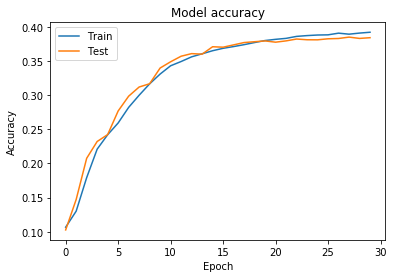

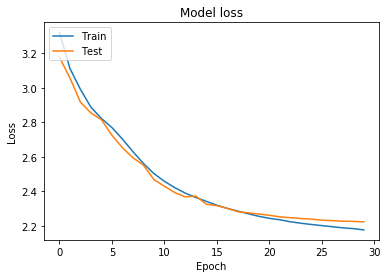

Training Time :  3328.7708711624146


In [46]:
import time

model_num = 5
test_size = 0.2

EPOCHS = 30
BATCH_SIZE = 256
#LIMIT_RATE = 0.95

start = time.time()
model_atten_before_new5,test_data_new5 = train_model(model_num,test_size)
print("Training Time : ", time.time() - start)

model_atten_before_new5.save('model_atten_before_new5.h5')

permute_12
10 294
----- activations -----
(1, 10, 294)
attention = [0.07218487 0.05336062 0.08075129 0.08470177 0.08756223 0.09852668
 0.07737137 0.12510973 0.10176746 0.21866398]
----- activations -----
(1, 10, 294)
attention = [0.06443891 0.05063181 0.07411056 0.10544464 0.08675823 0.09165071
 0.09259076 0.10305987 0.12660897 0.20470554]
----- activations -----
(1, 10, 294)
attention = [0.07765824 0.06181858 0.08028714 0.09450865 0.07329776 0.09277803
 0.08244724 0.12222778 0.11212795 0.2028486 ]
----- activations -----
(1, 10, 294)
attention = [0.06780525 0.05516947 0.08579668 0.07967874 0.08447705 0.10093548
 0.09170028 0.11512738 0.10112474 0.21818493]
----- activations -----
(1, 10, 294)
attention = [0.0535428  0.0672282  0.07673368 0.04529047 0.04961101 0.05766982
 0.09019885 0.08251173 0.3145036  0.16270988]
----- activations -----
(1, 10, 294)
attention = [0.07521052 0.06370091 0.06829142 0.07306416 0.07120045 0.09804001
 0.08053903 0.12772036 0.10561979 0.23661338]
----- acti

(1, 10, 294)
attention = [0.0639392  0.061072   0.0722511  0.07549478 0.06628757 0.11898325
 0.08908581 0.10646944 0.10292884 0.24348803]
----- activations -----
(1, 10, 294)
attention = [0.05314527 0.05243699 0.07872754 0.05548163 0.03850849 0.06797356
 0.08972    0.09058359 0.3159517  0.15747121]
----- activations -----
(1, 10, 294)
attention = [0.06135743 0.05964323 0.08062129 0.08132791 0.0766132  0.10801087
 0.09784678 0.10772464 0.12307981 0.20377485]
----- activations -----
(1, 10, 294)
attention = [0.07907848 0.05209979 0.08443804 0.08221029 0.06819719 0.09986348
 0.08940917 0.1131589  0.13242379 0.19912086]
----- activations -----
(1, 10, 294)
attention = [0.051257   0.05190282 0.07743672 0.06031442 0.03752198 0.05940472
 0.10523049 0.07497171 0.31325454 0.16870564]
----- activations -----
(1, 10, 294)
attention = [0.06937326 0.05117749 0.07014325 0.10109624 0.06120879 0.09813917
 0.08493672 0.12933822 0.09691039 0.23767646]
----- activations -----
(1, 10, 294)
attention = [0.

(1, 10, 294)
attention = [0.04383922 0.04411879 0.08337516 0.0606596  0.03839109 0.05379778
 0.07403445 0.11005376 0.317564   0.17416617]
----- activations -----
(1, 10, 294)
attention = [0.05159558 0.0548842  0.09388645 0.05897202 0.03775236 0.06910226
 0.08569352 0.08970755 0.3091281  0.14927796]
----- activations -----
(1, 10, 294)
attention = [0.0460596  0.05007957 0.08851532 0.0516957  0.04993939 0.05369498
 0.09505273 0.08128572 0.33109355 0.15258342]
----- activations -----
(1, 10, 294)
attention = [0.05841183 0.05505109 0.07748512 0.0859926  0.07207466 0.09143723
 0.09951716 0.09870708 0.11112425 0.25019893]
----- activations -----
(1, 10, 294)
attention = [0.05869551 0.05622494 0.06859221 0.08101029 0.08106797 0.10158968
 0.08353201 0.10984501 0.11637805 0.24306433]
----- activations -----
(1, 10, 294)
attention = [0.07090013 0.060963   0.08277644 0.0803463  0.06639726 0.0849636
 0.09547123 0.11588681 0.09939427 0.24290098]
----- activations -----
(1, 10, 294)
attention = [0.0

(1, 10, 294)
attention = [0.06538325 0.04295215 0.07489181 0.04635557 0.04373332 0.0669729
 0.07710432 0.10247678 0.33841416 0.14171572]
----- activations -----
(1, 10, 294)
attention = [0.05711826 0.05868681 0.07561771 0.10223804 0.07719498 0.10945443
 0.1063962  0.08637761 0.11996626 0.20694971]
----- activations -----
(1, 10, 294)
attention = [0.04635002 0.05750699 0.08642736 0.05362026 0.03924707 0.06359764
 0.09513932 0.07495722 0.33444425 0.14870988]
----- activations -----
(1, 10, 294)
attention = [0.05582878 0.06277221 0.08515402 0.07010417 0.07075495 0.10367353
 0.10118441 0.10474391 0.12657183 0.21921214]
----- activations -----
(1, 10, 294)
attention = [0.05604837 0.06232012 0.08113445 0.09591026 0.07042547 0.10651652
 0.08735893 0.10554979 0.10415355 0.23058254]
----- activations -----
(1, 10, 294)
attention = [0.05023215 0.05899977 0.07836797 0.06363059 0.03990693 0.05619182
 0.08234869 0.08665333 0.3271656  0.15650313]
----- activations -----
(1, 10, 294)
attention = [0.0

(1, 10, 294)
attention = [0.05648913 0.05477389 0.0665675  0.05598935 0.03926021 0.07767884
 0.08305999 0.10249593 0.3052714  0.15841383]
----- activations -----
(1, 10, 294)
attention = [0.0444394  0.03818808 0.0851617  0.05628983 0.03305397 0.07075336
 0.08972971 0.09844103 0.31953353 0.1644094 ]
----- activations -----
(1, 10, 294)
attention = [0.05144147 0.05654389 0.08918115 0.0526124  0.04723593 0.05836421
 0.09204756 0.0986153  0.28133368 0.17262436]
----- activations -----
(1, 10, 294)
attention = [0.05536043 0.04180025 0.05919926 0.06213759 0.04058952 0.08307759
 0.08891971 0.07977782 0.32553092 0.16360691]
----- activations -----
(1, 10, 294)
attention = [0.06527007 0.05790883 0.10173343 0.07065067 0.09070103 0.08944412
 0.09036285 0.10848214 0.11539698 0.21004988]
----- activations -----
(1, 10, 294)
attention = [0.04403369 0.04422294 0.07252073 0.05790511 0.04510714 0.06729535
 0.09220742 0.08111186 0.30773053 0.18786526]
----- activations -----
(1, 10, 294)
attention = [0.

(1, 10, 294)
attention = [0.05742007 0.05501557 0.07488473 0.03710831 0.05423867 0.06862897
 0.08618407 0.08360483 0.31746414 0.16545066]
----- activations -----
(1, 10, 294)
attention = [0.06211475 0.04494103 0.09284004 0.08353211 0.06360094 0.09110115
 0.08574677 0.103511   0.11051708 0.26209512]
----- activations -----
(1, 10, 294)
attention = [0.06783476 0.05345672 0.08014128 0.09603479 0.0752956  0.10361736
 0.09811261 0.11426868 0.09441333 0.21682487]
----- activations -----
(1, 10, 294)
attention = [0.0585742  0.04950216 0.09113929 0.08300995 0.05628693 0.09559733
 0.09188362 0.10721086 0.11135051 0.25544512]
----- activations -----
(1, 10, 294)
attention = [0.06202493 0.05117324 0.07301808 0.0574498  0.04519131 0.07146668
 0.10028972 0.09493694 0.30199015 0.14245912]
----- activations -----
(1, 10, 294)
attention = [0.04690385 0.05271917 0.07492446 0.0676541  0.03420731 0.07018112
 0.09543052 0.08047468 0.3221132  0.1553916 ]
----- activations -----
(1, 10, 294)
attention = [0.

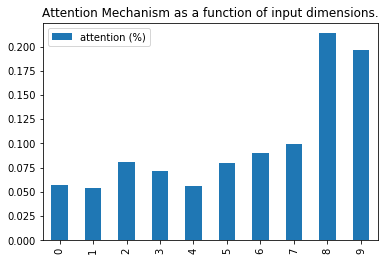

In [47]:
# check weights
layer_name ="permute_12"
show_attention_weight(model_atten_before_new5,layer_name)

one_hot_code:  (215424, 10, 294) (215424, 294)
len of train data:  172339
len of train data:  43085


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 10, 294)      0                                            
__________________________________________________________________________________________________
permute_15 (Permute)            (None, 294, 10)      0           input_8[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 294, 10)      0           permute_15[0][0]                 
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 294, 10)      110         reshape_8[0][0]                  
__________________________________________________________________________________________________
permute_16

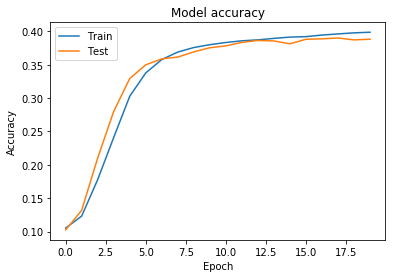

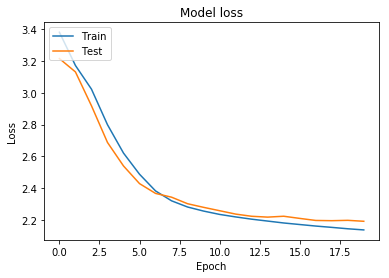

Training Time :  1838.4632518291473


In [60]:
import time

model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 256
#LIMIT_RATE = 0.95

start = time.time()
model_atten_before_new4,test_data_new4 = train_model(model_num,test_size)
print("Training Time : ", time.time() - start)

model_atten_before_new4.save('.h5')



one_hot_code:  (215424, 10, 294) (215424, 51)
len of train data:  172339
len of train data:  43085


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 10, 294)      0                                            
__________________________________________________________________________________________________
permute_23 (Permute)            (None, 294, 10)      0           input_12[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 294, 10)      0           permute_23[0][0]                 
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 294, 10)      110         reshape_12[0][0]                 
__________________________________________________________________________________________________
permute_24

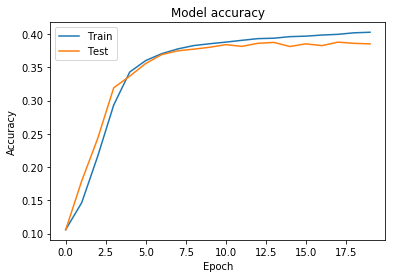

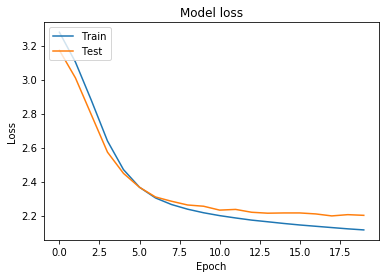

Training Time :  1858.6847219467163


In [120]:
import time

model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 256
#LIMIT_RATE = 0.95

start = time.time()
model_atten_before_new42,test_data_new42 = train_model(model_num,test_size)
print("Training Time : ", time.time() - start)

model_atten_before_new42.save('model_atten_before_new42.h5')

one_hot_code:  (215424, 20, 294) (215424, 51)
len of train data:  172339
len of train data:  43085
20


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_15 (Permute)            (None, 294, 20)      0           input_8[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 294, 20)      0           permute_15[0][0]                 
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 294, 20)      420         reshape_8[0][0]                  
__________________________________________________________________________________________________
permute_16

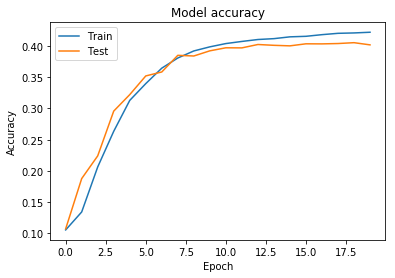

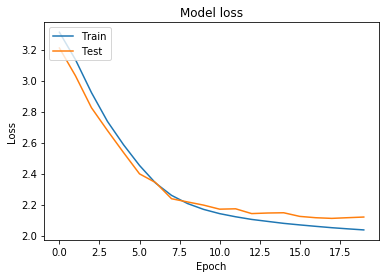

Training Time :  3904.8471949100494


In [52]:
# for time stemps 20
# set time stemps
time_stamps = 20

model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 256
#LIMIT_RATE = 0.95

start = time.time()
model_atten_before_new42_20t,test_data_new42_20t = train_model(model_num,test_size)
print("Training Time : ", time.time() - start)

model_atten_before_new42_20t.save('model_atten_before_new42_20t.h5')

permute_16
20 294
----- activations -----
(1, 20, 294)
attention = [0.0177202  0.01229752 0.00753138 0.0337511  0.01488567 0.02399057
 0.04484288 0.01700605 0.00604999 0.02043227 0.0384106  0.03012525
 0.03400725 0.04060572 0.02268193 0.04221283 0.08450922 0.04472073
 0.18410426 0.28011456]
----- activations -----
(1, 20, 294)
attention = [0.02488579 0.01545534 0.01234935 0.02710377 0.01834473 0.03412597
 0.04584993 0.0154275  0.00561442 0.01634371 0.04020993 0.02758012
 0.03796401 0.04304709 0.03523263 0.05037367 0.08681317 0.0447819
 0.16426487 0.25423208]
----- activations -----
(1, 20, 294)
attention = [0.02743016 0.01487753 0.01190566 0.02065232 0.02084164 0.03532761
 0.03354323 0.01670511 0.0068085  0.01812164 0.05535079 0.02810703
 0.02779149 0.04591834 0.03324314 0.05033537 0.073511   0.07137721
 0.16276856 0.24538366]
----- activations -----
(1, 20, 294)
attention = [0.02587967 0.01421442 0.01101787 0.02513718 0.01469449 0.0344172
 0.03873877 0.01968442 0.00596129 0.02020049 0

(1, 20, 294)
attention = [0.023309   0.00637551 0.00527209 0.00908347 0.02249805 0.01855666
 0.03146708 0.01982794 0.03647583 0.02336857 0.05238198 0.03777285
 0.02345155 0.06042637 0.01704411 0.07172371 0.10359834 0.0506943
 0.14504632 0.24162625]
----- activations -----
(1, 20, 294)
attention = [0.02305827 0.00830809 0.00666992 0.01492018 0.02298722 0.01750732
 0.03401724 0.01571099 0.03784113 0.02972958 0.0616593  0.03563815
 0.02638711 0.07106344 0.01651473 0.06301238 0.11856224 0.04970563
 0.12813532 0.21857177]
----- activations -----
(1, 20, 294)
attention = [0.02082309 0.00479413 0.00708527 0.01156756 0.0173146  0.02549024
 0.02890906 0.01822575 0.04739406 0.02745694 0.0532152  0.0339728
 0.02624769 0.05961332 0.01791406 0.06723585 0.12300642 0.06660386
 0.11920938 0.22392076]
----- activations -----
(1, 20, 294)
attention = [0.01545399 0.00640539 0.00787891 0.01383257 0.01902587 0.01773765
 0.02801512 0.0190723  0.04068492 0.02364828 0.04968182 0.03605746
 0.03400021 0.0505372

(1, 20, 294)
attention = [0.02320978 0.01668766 0.01366123 0.03276353 0.01665772 0.02660883
 0.02792781 0.01172651 0.00578821 0.01958072 0.03754092 0.02659546
 0.02926446 0.04096133 0.0360239  0.04625016 0.09350628 0.07045226
 0.17425485 0.2505384 ]
----- activations -----
(1, 20, 294)
attention = [0.01786192 0.01241915 0.01457515 0.02961668 0.0212252  0.02280511
 0.04386419 0.01541273 0.00514286 0.01442279 0.03665622 0.03049885
 0.01983422 0.03084157 0.02896066 0.05407887 0.07093745 0.04801457
 0.17796768 0.3048641 ]
----- activations -----
(1, 20, 294)
attention = [0.0291061  0.00703919 0.01037014 0.01225066 0.0212711  0.0268843
 0.02146666 0.01625522 0.03115957 0.0254363  0.05494743 0.02795298
 0.03615997 0.04902071 0.0220649  0.05704058 0.11482552 0.05974648
 0.15909953 0.21790265]
----- activations -----
(1, 20, 294)
attention = [0.02428586 0.00544526 0.00930721 0.0165509  0.01883035 0.02037458
 0.02976069 0.01274118 0.03691809 0.02544929 0.05564237 0.02648946
 0.03791998 0.058071

(1, 20, 294)
attention = [0.0233635  0.00825218 0.00860934 0.00764345 0.01743074 0.01767113
 0.0266019  0.01474672 0.03369198 0.01840485 0.0495089  0.02312864
 0.02287254 0.05013296 0.02119387 0.0793501  0.11671375 0.05518002
 0.13572718 0.26977623]
----- activations -----
(1, 20, 294)
attention = [0.02336353 0.01471263 0.01084746 0.02170819 0.01794214 0.02738607
 0.02699379 0.01267676 0.00422944 0.02232889 0.04463142 0.02520953
 0.0283708  0.04161212 0.02195296 0.05081813 0.07549178 0.05327834
 0.16381063 0.31263542]
----- activations -----
(1, 20, 294)
attention = [0.02710242 0.01255304 0.01276789 0.01680364 0.0262089  0.02732198
 0.0388796  0.02130701 0.00684694 0.02187417 0.04176366 0.03839676
 0.02813511 0.04169175 0.03899404 0.04776478 0.05758296 0.06495553
 0.16242245 0.26662737]
----- activations -----
(1, 20, 294)
attention = [0.0227924  0.00658322 0.00742434 0.01355821 0.01295359 0.01639702
 0.02836895 0.01561721 0.02743763 0.02096388 0.05843954 0.02643797
 0.02709672 0.04929

(1, 20, 294)
attention = [0.01592495 0.01165385 0.01140028 0.02028131 0.01751609 0.03425547
 0.02856772 0.01890243 0.00571908 0.03551546 0.06257071 0.03423044
 0.03466357 0.03845035 0.03366789 0.04516528 0.0707619  0.06318707
 0.16266783 0.25489834]
----- activations -----
(1, 20, 294)
attention = [0.02274775 0.01072757 0.01089995 0.02565068 0.02237892 0.02285124
 0.04614324 0.01805353 0.00546404 0.02226493 0.03792867 0.02716602
 0.03092931 0.03718473 0.03170144 0.03783546 0.08579882 0.0759124
 0.17915608 0.24920522]
----- activations -----
(1, 20, 294)
attention = [0.03120581 0.00986605 0.01276464 0.02258638 0.0193647  0.0237359
 0.0357223  0.01359736 0.00620016 0.01688263 0.03914352 0.02733451
 0.02733294 0.0406463  0.03854227 0.05032079 0.0861467  0.06601958
 0.13815606 0.29443142]
----- activations -----
(1, 20, 294)
attention = [0.01375411 0.00384142 0.0080923  0.00921826 0.01960559 0.0170163
 0.03553645 0.02066285 0.03891074 0.02353927 0.04642986 0.04101935
 0.03036561 0.05534486

(1, 20, 294)
attention = [0.02408676 0.01230143 0.01108045 0.0209579  0.02020288 0.030739
 0.04607132 0.0180511  0.00706466 0.02189534 0.03616186 0.03301551
 0.03204144 0.03938467 0.03546452 0.05874683 0.09703829 0.06898881
 0.15635276 0.23035446]
----- activations -----
(1, 20, 294)
attention = [0.02595893 0.01489976 0.01188189 0.03219948 0.01539685 0.0246889
 0.04125299 0.01524539 0.00552301 0.02302166 0.05047327 0.03375225
 0.02284698 0.03837159 0.02469843 0.06258395 0.07542403 0.06439167
 0.1661884  0.2512006 ]
----- activations -----
(1, 20, 294)
attention = [0.02686426 0.01105611 0.01335302 0.01357093 0.02113472 0.03046764
 0.04790929 0.01539605 0.00566951 0.01614157 0.03980621 0.02314621
 0.02803675 0.04084562 0.03938524 0.05532391 0.08179301 0.05958948
 0.15835169 0.2721588 ]
----- activations -----
(1, 20, 294)
attention = [0.01923138 0.0134728  0.00943013 0.0255211  0.01804207 0.01993572
 0.03103585 0.02312773 0.00510533 0.02052215 0.05630732 0.02475598
 0.02958457 0.05491471

(1, 20, 294)
attention = [0.02575611 0.0195624  0.0157592  0.02021481 0.02751076 0.03725419
 0.05924664 0.01862657 0.00743511 0.02821283 0.05026392 0.0341707
 0.02867804 0.03239558 0.03299008 0.04926015 0.07893924 0.03839313
 0.14227638 0.2530541 ]
----- activations -----
(1, 20, 294)
attention = [0.01779179 0.00609259 0.00898372 0.01947653 0.01917928 0.03071545
 0.0275908  0.0184929  0.04494065 0.02157444 0.05238073 0.03788225
 0.03057662 0.05385697 0.02120818 0.06262629 0.09659204 0.0549798
 0.10766152 0.26739746]
----- activations -----
(1, 20, 294)
attention = [0.02623894 0.00950227 0.00848148 0.01559748 0.01998167 0.01546067
 0.02510765 0.01666783 0.03617118 0.02024451 0.05463788 0.02987573
 0.02572195 0.04693475 0.03037886 0.07068398 0.10212635 0.05671929
 0.1509804  0.23848714]
----- activations -----
(1, 20, 294)
attention = [0.01967821 0.00406349 0.00737642 0.013894   0.02185629 0.01523902
 0.03414515 0.01244566 0.0361935  0.02127725 0.06126667 0.03148742
 0.02981185 0.0421502

(1, 20, 294)
attention = [0.0281195  0.00653286 0.00658055 0.01121098 0.01913123 0.02270419
 0.02706063 0.01943145 0.03713955 0.01914844 0.05568506 0.03822555
 0.02777588 0.05225224 0.02031992 0.05299047 0.11052802 0.07433946
 0.15843652 0.21238749]
----- activations -----
(1, 20, 294)
attention = [0.02681633 0.01481497 0.00952764 0.02386648 0.01871832 0.04015442
 0.03179668 0.0135093  0.00571304 0.01664053 0.04533533 0.03848409
 0.0290416  0.04896864 0.03800513 0.06016345 0.07204962 0.07469349
 0.12771888 0.2639821 ]
----- activations -----
(1, 20, 294)
attention = [0.01861229 0.01219411 0.0139504  0.02062746 0.02270615 0.02275542
 0.04715185 0.01710848 0.00500044 0.02731388 0.0380545  0.02300392
 0.02613755 0.03467942 0.03315167 0.07063903 0.0678224  0.07252031
 0.17803928 0.24853145]
----- activations -----
(1, 20, 294)
attention = [0.03820937 0.01127249 0.00984335 0.02799178 0.02118657 0.02660971
 0.03976601 0.01602056 0.00721661 0.0178353  0.03956575 0.0331449
 0.02573947 0.049988

(1, 20, 294)
attention = [0.02651285 0.01087333 0.00827861 0.02095032 0.01912556 0.02833513
 0.04150263 0.01910739 0.00537355 0.03804284 0.04593968 0.03566502
 0.02697191 0.03647086 0.03036208 0.05679146 0.08429391 0.05922811
 0.16964966 0.23652513]
----- activations -----
(1, 20, 294)
attention = [0.01549848 0.0052391  0.00821177 0.01427028 0.01816219 0.03011599
 0.04377906 0.01597918 0.04112163 0.02426341 0.04260644 0.02962108
 0.03737817 0.06034094 0.02073075 0.07637906 0.10782178 0.05027096
 0.12026498 0.23794475]
----- activations -----
(1, 20, 294)
attention = [0.02304576 0.00681409 0.00604074 0.01244018 0.01673056 0.01955649
 0.03074996 0.01483208 0.03606058 0.02562334 0.05126248 0.03310787
 0.03215024 0.05278322 0.02262842 0.06792322 0.10862805 0.05891252
 0.15545487 0.22525536]
----- activations -----
(1, 20, 294)
attention = [0.02033668 0.01194785 0.00913269 0.02595972 0.02470811 0.03120136
 0.03293586 0.0143056  0.00603072 0.02316979 0.03840934 0.03697118
 0.02783172 0.03299

(1, 20, 294)
attention = [0.0249746  0.00727421 0.00542727 0.01261706 0.01581359 0.02757548
 0.02928065 0.01657029 0.03300648 0.02396335 0.05206927 0.01909582
 0.03231461 0.0557169  0.02221046 0.07889805 0.1108352  0.05772466
 0.12428282 0.25034925]
----- activations -----
(1, 20, 294)
attention = [0.02771981 0.01138068 0.00977084 0.02508949 0.02324883 0.02887902
 0.02540516 0.01580032 0.00484593 0.01658449 0.04042007 0.02643639
 0.03171455 0.05266821 0.0267325  0.0349417  0.09203888 0.05113784
 0.16468184 0.29050344]
----- activations -----
(1, 20, 294)
attention = [0.0192073  0.00561841 0.00438649 0.01283988 0.01277611 0.02144706
 0.02691182 0.01458887 0.03232829 0.02469331 0.05482837 0.03021749
 0.03361832 0.05844097 0.02583426 0.06424244 0.12074406 0.05230695
 0.14539893 0.23957066]
----- activations -----
(1, 20, 294)
attention = [0.02832869 0.01002324 0.0127176  0.01853234 0.01836866 0.02919918
 0.04045653 0.01262857 0.00713223 0.01677867 0.0477439  0.02182373
 0.02028434 0.03371

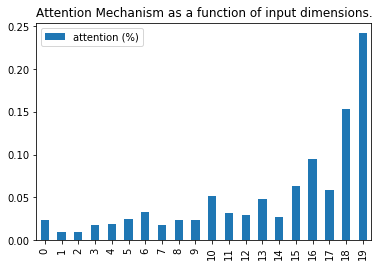

In [53]:
layer_name ="permute_16"
show_attention_weight(model_atten_before_new42_20t,layer_name)

one_hot_code:  (215424, 30, 294) (215424, 51)
len of train data:  172339
len of train data:  43085
30


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 30, 294)      0                                            
__________________________________________________________________________________________________
permute_19 (Permute)            (None, 294, 30)      0           input_10[0][0]                   
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 294, 30)      0           permute_19[0][0]                 
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 294, 30)      930         reshape_10[0][0]                 
__________________________________________________________________________________________________
permute_20

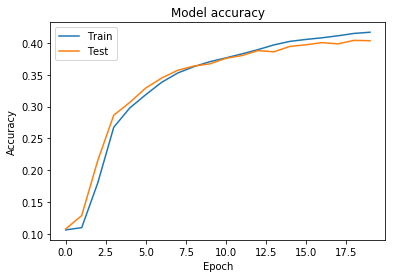

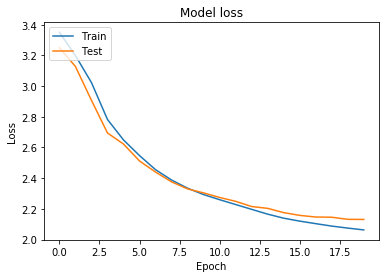

Training Time :  6563.239037036896


In [57]:
# for time stemps 30
# set time stemps
time_stamps = 30

model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 256
#LIMIT_RATE = 0.95

start = time.time()
model_atten_before_new42_30t,test_data_new42_30t = train_model(model_num,test_size)
print("Training Time : ", time.time() - start)

model_atten_before_new42_30t.save('model_atten_before_new42_30t.h5')

permute_20
30 294
----- activations -----
(1, 30, 294)
attention = [1.57403890e-02 8.03282671e-03 6.79340446e-04 6.84587285e-05
 2.54349114e-04 1.78281305e-04 3.21697764e-04 7.41286727e-04
 3.64510517e-04 9.02339700e-04 2.18024454e-03 2.84753903e-03
 2.80867703e-03 1.84908547e-02 3.11572533e-02 1.90963726e-02
 3.32171023e-02 2.15123203e-02 3.19202691e-02 3.98702882e-02
 5.71884625e-02 2.98757609e-02 5.19197881e-02 5.01462892e-02
 3.81281078e-02 4.86495830e-02 7.93010592e-02 1.01356484e-01
 9.68887806e-02 2.16161281e-01]
----- activations -----
(1, 30, 294)
attention = [0.02386168 0.01448591 0.0009181  0.00023464 0.00030351 0.00031367
 0.00055621 0.00133102 0.00050296 0.00091798 0.00265986 0.00757464
 0.00709291 0.02582056 0.029993   0.01574635 0.02675198 0.02284313
 0.05568267 0.03743791 0.03508912 0.03180972 0.06502296 0.03413697
 0.05604851 0.04551217 0.09113111 0.06540056 0.08937412 0.21144602]
----- activations -----
(1, 30, 294)
attention = [2.3459667e-02 1.3117208e-02 9.3822577e-

(1, 30, 294)
attention = [1.9673785e-02 6.7267087e-03 6.6430209e-04 9.6285083e-05 5.2212673e-04
 2.6110283e-04 3.8903335e-04 3.9170287e-04 5.3481193e-04 9.5600943e-04
 6.8179565e-03 4.1070967e-03 4.1913036e-03 1.7501336e-02 1.6339075e-02
 2.6640477e-02 3.5821032e-02 2.5339533e-02 3.6356330e-02 5.6309778e-02
 4.0444583e-02 6.1236065e-02 5.8169752e-02 3.8501073e-02 4.3427855e-02
 4.9910281e-02 5.4879051e-02 8.3216675e-02 9.0573050e-02 2.2000185e-01]
----- activations -----
(1, 30, 294)
attention = [1.97197888e-02 8.91038962e-03 3.44346132e-04 1.43802361e-04
 5.43314382e-04 5.27622178e-04 5.95676480e-04 1.20223546e-03
 5.35757339e-04 9.18824342e-04 4.42939205e-03 3.02832457e-03
 4.58013453e-03 1.72523670e-02 1.51364496e-02 2.26958375e-02
 2.97421925e-02 2.32428182e-02 4.83752936e-02 4.94856983e-02
 7.56452158e-02 4.41834144e-02 7.12909177e-02 4.11074422e-02
 1.78651847e-02 5.62073700e-02 6.23201318e-02 8.25853348e-02
 1.03187755e-01 1.94196969e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [2.5902247e-02 1.1955665e-02 7.2570168e-04 1.2755232e-04 3.7481476e-04
 4.2757072e-04 4.0831132e-04 9.2384056e-04 5.0121843e-04 7.1986078e-04
 4.0812171e-03 4.6370532e-03 5.8309170e-03 2.6086412e-02 1.8591855e-02
 2.1830782e-02 1.8111879e-02 2.2365453e-02 3.2928202e-02 4.2564951e-02
 6.0050186e-02 4.9284033e-02 6.8448633e-02 4.0417787e-02 2.6663505e-02
 5.3547386e-02 6.5709792e-02 1.1223877e-01 9.6677609e-02 1.8786679e-01]
----- activations -----
(1, 30, 294)
attention = [1.7166609e-02 1.0596631e-02 7.9139537e-04 1.2315113e-04 3.2672138e-04
 2.2158212e-04 2.8694948e-04 6.0297851e-04 4.5878120e-04 8.5138902e-04
 5.4575941e-03 5.1415269e-03 4.9769520e-03 2.3583401e-02 2.3495516e-02
 9.1151595e-03 2.2210428e-02 3.6801156e-02 2.9112339e-02 5.3376906e-02
 5.2797522e-02 2.9741909e-02 5.9340112e-02 5.4880306e-02 2.7265435e-02
 7.7727966e-02 6.5684013e-02 1.0123291e-01 7.4336827e-02 2.1229583e-01]
----- activations -----
(1, 30, 294)
attention = [0.01311412 0.01253971 

(1, 30, 294)
attention = [0.01618825 0.00697579 0.00058352 0.00025984 0.00074902 0.0003202
 0.00060512 0.00156667 0.00086239 0.00176377 0.00323347 0.00456944
 0.00586755 0.01914571 0.01465226 0.02563317 0.03354488 0.01825741
 0.0588704  0.06471328 0.07273392 0.03799738 0.06645147 0.039356
 0.03329596 0.05149831 0.05821303 0.05111591 0.09819174 0.21278413]
----- activations -----
(1, 30, 294)
attention = [1.83530319e-02 1.40984785e-02 4.81052411e-04 7.90831109e-05
 2.36866297e-04 1.88148289e-04 2.03860734e-04 5.91319927e-04
 3.24109627e-04 3.85594962e-04 3.17799835e-03 2.13693362e-03
 3.49110528e-03 1.77474227e-02 1.43087693e-02 3.18117999e-02
 2.44905632e-02 2.14256551e-02 4.30342630e-02 3.65667269e-02
 4.95548137e-02 4.77697290e-02 5.87598830e-02 4.81746532e-02
 2.96529587e-02 6.51559010e-02 8.41462016e-02 7.91013837e-02
 8.41546580e-02 2.20397040e-01]
----- activations -----
(1, 30, 294)
attention = [1.6948188e-02 9.3708429e-03 1.5348609e-03 8.7107641e-05 3.8138483e-04
 2.8947604e-04

(1, 30, 294)
attention = [0.01486846 0.0116151  0.00040043 0.00039386 0.00044647 0.00030123
 0.00075939 0.00088114 0.00096507 0.00132782 0.00345984 0.00400242
 0.00338152 0.02624564 0.02907913 0.01328365 0.02907367 0.01852002
 0.05404131 0.04708316 0.04966234 0.06126414 0.06454357 0.04542683
 0.03299781 0.06825361 0.06459726 0.07701561 0.08122589 0.19488361]
----- activations -----
(1, 30, 294)
attention = [1.6074043e-02 1.1091621e-02 4.2003722e-04 7.2169401e-05 5.3850224e-04
 1.7004876e-04 4.7436124e-04 1.4334058e-03 6.1022589e-04 9.8599354e-04
 3.4375053e-03 3.7385509e-03 3.5420789e-03 2.1716440e-02 2.5733098e-02
 1.8819062e-02 2.7318796e-02 2.6006358e-02 4.3943670e-02 4.2607170e-02
 5.4885294e-02 5.6221072e-02 7.9336278e-02 5.1822752e-02 3.6097914e-02
 6.0149394e-02 5.9449311e-02 5.5475436e-02 9.8205574e-02 1.9962387e-01]
----- activations -----
(1, 30, 294)
attention = [1.7887803e-02 8.2105938e-03 1.0665986e-03 1.1040284e-04 4.9513089e-04
 3.6792792e-04 5.9580675e-04 8.6458988e-04 

(1, 30, 294)
attention = [1.5123621e-02 9.0662651e-03 3.9967388e-04 9.0552800e-05 3.7660464e-04
 2.3765131e-04 2.8357023e-04 6.5209379e-04 5.0598796e-04 1.0117849e-03
 2.4246525e-03 2.5221528e-03 4.0285136e-03 1.9855075e-02 1.4305887e-02
 1.7469678e-02 4.0929496e-02 2.9061859e-02 4.2098388e-02 6.3740909e-02
 6.1035726e-02 4.7951680e-02 4.0394116e-02 4.2669922e-02 3.4922387e-02
 5.5982728e-02 7.7449329e-02 7.2774068e-02 9.5000803e-02 2.0763482e-01]
----- activations -----
(1, 30, 294)
attention = [1.58554949e-02 8.19301326e-03 6.09969429e-04 8.74084217e-05
 5.67960495e-04 4.24427766e-04 3.57137353e-04 3.61837097e-04
 1.04805629e-03 8.64084868e-04 5.49064623e-03 7.40735140e-03
 7.58915441e-03 1.77847445e-02 2.30567306e-02 1.89759266e-02
 2.38619987e-02 2.45564189e-02 3.55059505e-02 3.89449559e-02
 5.72864376e-02 5.51605821e-02 4.77813333e-02 5.02858572e-02
 4.80916165e-02 5.29238544e-02 7.08225891e-02 7.54495040e-02
 1.01106435e-01 2.09548503e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.2008272e-02 7.1900473e-03 6.4486574e-04 1.4901516e-04 7.3787937e-04
 5.1120785e-04 2.8255294e-04 6.7676976e-04 4.4984205e-04 7.0737704e-04
 5.4706028e-03 7.7512749e-03 5.4410421e-03 1.4730465e-02 2.3946067e-02
 2.4468379e-02 1.9153375e-02 1.9240871e-02 4.3644790e-02 5.2075535e-02
 7.0414141e-02 3.4491163e-02 7.1516134e-02 4.3007463e-02 3.4488160e-02
 5.2594785e-02 7.4711844e-02 7.5889610e-02 1.0255828e-01 2.0104817e-01]
----- activations -----
(1, 30, 294)
attention = [2.6394960e-02 9.5622092e-03 2.9972004e-04 7.6749609e-05 2.2270634e-04
 1.9509414e-04 3.4558942e-04 4.7642362e-04 5.1382487e-04 7.8469899e-04
 2.2584167e-03 4.9091559e-03 3.4429312e-03 1.4357982e-02 1.7800990e-02
 1.2500336e-02 2.2399202e-02 2.4759013e-02 4.9650166e-02 3.7981827e-02
 6.1290961e-02 3.6014643e-02 6.2503591e-02 3.7981521e-02 4.0406700e-02
 5.9540275e-02 6.3608326e-02 7.6091029e-02 8.6674117e-02 2.4695683e-01]
----- activations -----
(1, 30, 294)
attention = [2.3110306e-02 1.261009

(1, 30, 294)
attention = [2.2363123e-02 1.1442689e-02 7.3925074e-04 9.6012714e-05 3.1715521e-04
 3.9463578e-04 3.5741448e-04 3.3955736e-04 3.5532744e-04 5.6923821e-04
 6.6980030e-03 5.1117414e-03 4.2394432e-03 1.9533742e-02 2.2469060e-02
 1.6980967e-02 2.6291087e-02 2.6965475e-02 4.5272496e-02 3.8196765e-02
 6.4813308e-02 4.5032330e-02 6.4187065e-02 4.6239801e-02 3.7130553e-02
 5.4326896e-02 6.2463824e-02 8.1563339e-02 9.7421758e-02 1.9808793e-01]
----- activations -----
(1, 30, 294)
attention = [2.50680465e-02 8.86680186e-03 6.18317688e-04 1.17076146e-04
 6.36560260e-04 4.44409350e-04 4.61610209e-04 3.63618019e-04
 6.74024748e-04 9.56043601e-04 3.94496182e-03 3.83206457e-03
 4.10584873e-03 2.20480449e-02 2.09531821e-02 1.83242410e-02
 1.94722749e-02 1.98163223e-02 6.32767603e-02 4.68252003e-02
 4.01433967e-02 4.66329306e-02 8.48340765e-02 5.56965768e-02
 2.97149047e-02 5.55008724e-02 5.92167377e-02 8.80296528e-02
 8.52888301e-02 1.94136620e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.54876290e-02 1.36284325e-02 3.83909501e-04 9.84578655e-05
 3.09319817e-04 1.99663249e-04 3.10049159e-04 5.08932106e-04
 4.73863911e-04 9.28597408e-04 3.96220433e-03 3.31910281e-03
 1.92417088e-03 2.51551550e-02 2.17868220e-02 1.18576130e-02
 2.44434457e-02 1.68110635e-02 4.41570841e-02 5.97654320e-02
 5.56116812e-02 6.11009933e-02 7.23361447e-02 3.92179228e-02
 4.84504774e-02 6.16857745e-02 6.40235916e-02 8.84059742e-02
 7.27971792e-02 1.90859318e-01]
----- activations -----
(1, 30, 294)
attention = [1.9431334e-02 1.0249449e-02 5.2876986e-04 9.7464930e-05 3.5176304e-04
 2.6176899e-04 4.8998120e-04 6.8866293e-04 6.9598336e-04 9.7218977e-04
 4.6671885e-03 5.9654298e-03 5.0427108e-03 1.4639920e-02 2.1675287e-02
 2.3723839e-02 2.6143484e-02 3.2056510e-02 3.7732791e-02 5.9777826e-02
 5.7892617e-02 4.7189344e-02 5.4960608e-02 3.2468453e-02 3.2587625e-02
 5.2435614e-02 7.1548656e-02 6.7741059e-02 8.7479770e-02 2.3050389e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.9346129e-02 6.5812212e-03 4.9853540e-04 7.8448473e-05 2.7621750e-04
 2.2959532e-04 2.9798137e-04 2.8888648e-04 3.8858553e-04 6.9473847e-04
 5.2997298e-03 5.0576855e-03 3.5726074e-03 1.4464508e-02 2.1375237e-02
 2.3315912e-02 3.1711359e-02 1.8465880e-02 4.0620994e-02 4.6334479e-02
 5.3611428e-02 4.4191938e-02 7.5759836e-02 4.8856769e-02 2.6771225e-02
 6.7170814e-02 7.3181488e-02 9.2304088e-02 7.4370950e-02 2.0488274e-01]
----- activations -----
(1, 30, 294)
attention = [1.2277697e-02 9.9318204e-03 1.6135777e-03 6.9894500e-05 3.8035438e-04
 2.7404362e-04 2.0501450e-04 6.9726171e-04 3.8317448e-04 5.6777854e-04
 3.9767418e-03 6.3416786e-03 4.9742372e-03 2.2526437e-02 2.7639182e-02
 2.3311011e-02 2.5240563e-02 4.3394655e-02 4.8337620e-02 3.3583172e-02
 4.3311696e-02 6.4692527e-02 3.8306009e-02 4.6175774e-02 4.0508449e-02
 5.4918457e-02 7.0429794e-02 7.5219534e-02 8.9103028e-02 2.1160878e-01]
----- activations -----
(1, 30, 294)
attention = [2.3861712e-02 1.511193

(1, 30, 294)
attention = [2.7627613e-02 1.1967521e-02 4.1980497e-04 8.0271820e-05 3.6344491e-04
 3.4315186e-04 2.0251825e-04 5.4134300e-04 4.4551204e-04 6.6498586e-04
 3.6785100e-03 5.6879162e-03 4.9549337e-03 1.6748497e-02 2.6986904e-02
 1.5831778e-02 3.8787283e-02 3.0944098e-02 4.6351518e-02 3.0715469e-02
 4.3572240e-02 3.6234267e-02 5.5064540e-02 5.7408839e-02 3.6705237e-02
 7.6554477e-02 7.7505648e-02 7.2879441e-02 7.3564388e-02 2.0716785e-01]
----- activations -----
(1, 30, 294)
attention = [2.1871891e-02 1.0014840e-02 9.9831342e-04 1.2440630e-04 3.3762361e-04
 5.3299672e-04 2.0976656e-04 5.8910513e-04 3.5835666e-04 4.8565699e-04
 5.3089573e-03 7.1887271e-03 5.4305573e-03 1.5106860e-02 2.5531186e-02
 2.6945321e-02 2.2227038e-02 2.8697303e-02 3.8197707e-02 4.3057889e-02
 6.2711947e-02 2.9774459e-02 6.1796531e-02 4.4098504e-02 2.3641260e-02
 4.2522088e-02 6.3169844e-02 7.7997766e-02 1.0948510e-01 2.3158801e-01]
----- activations -----
(1, 30, 294)
attention = [1.2321554e-02 8.488521

(1, 30, 294)
attention = [1.5429474e-02 1.1609140e-02 5.0513353e-04 9.8861870e-05 4.8230711e-04
 2.5108014e-04 3.8456541e-04 1.5490252e-03 4.6223600e-04 8.8666857e-04
 4.3849354e-03 4.5160782e-03 3.5140757e-03 2.2609649e-02 2.8335754e-02
 1.2977833e-02 2.5199600e-02 3.2219850e-02 3.1841706e-02 4.5602325e-02
 5.3830963e-02 3.9607212e-02 5.6389946e-02 3.2362625e-02 4.9524486e-02
 5.6392733e-02 7.9789117e-02 8.1586771e-02 9.3888693e-02 2.1376717e-01]
----- activations -----
(1, 30, 294)
attention = [1.9157100e-02 1.0813348e-02 9.1364747e-04 5.3505635e-05 1.7414580e-04
 1.9191735e-04 1.3207056e-04 1.2777678e-03 2.0552265e-04 3.9222662e-04
 3.8597025e-03 6.2712803e-03 7.7169458e-03 1.6887262e-02 2.6300244e-02
 1.2123407e-02 3.1759501e-02 2.1415306e-02 7.7763990e-02 6.2191773e-02
 5.6540780e-02 4.6772465e-02 4.9592394e-02 4.5323100e-02 1.8387668e-02
 4.6520643e-02 7.1880519e-02 9.2949919e-02 9.6313581e-02 1.7611825e-01]
----- activations -----
(1, 30, 294)
attention = [2.01074518e-02 1.11304

(1, 30, 294)
attention = [1.63924973e-02 6.35208469e-03 3.78361146e-04 1.35629452e-04
 4.05933242e-04 4.38453746e-04 3.28627124e-04 7.57408969e-04
 6.43056293e-04 7.82233139e-04 4.39222716e-03 4.90054442e-03
 4.15270217e-03 1.30558675e-02 2.70060915e-02 3.46363932e-02
 2.75329705e-02 1.43613406e-02 4.63384651e-02 4.27960344e-02
 5.20354323e-02 4.21378464e-02 6.94766268e-02 3.05784345e-02
 2.98972782e-02 5.56914546e-02 5.99985719e-02 7.36575201e-02
 1.14971787e-01 2.25768164e-01]
----- activations -----
(1, 30, 294)
attention = [1.4247768e-02 1.1181169e-02 7.3781610e-04 1.1054657e-04 2.9261273e-04
 4.2684350e-04 2.4292839e-04 7.7345397e-04 3.7715639e-04 6.3335832e-04
 5.1967441e-03 4.6294788e-03 4.2695617e-03 1.7885979e-02 2.3414800e-02
 3.2688282e-02 1.9491863e-02 2.7303137e-02 3.4987792e-02 4.5780938e-02
 4.6750691e-02 3.1048233e-02 6.0016379e-02 3.6367781e-02 4.2972546e-02
 5.2498844e-02 8.1618518e-02 8.6738609e-02 1.1661537e-01 2.0070080e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.75710153e-02 9.11509246e-03 5.57671010e-04 1.18896605e-04
 7.81105889e-04 3.46730842e-04 4.08720342e-04 8.28067772e-04
 5.87090268e-04 1.26995111e-03 5.31283207e-03 3.51754529e-03
 3.71439033e-03 1.81306079e-02 1.85716972e-02 1.26366112e-02
 3.20538469e-02 2.33693905e-02 3.95918526e-02 5.16831800e-02
 5.32367341e-02 3.85920703e-02 4.74672131e-02 3.32256891e-02
 3.24633606e-02 5.51537871e-02 6.77670613e-02 7.72969872e-02
 1.27015665e-01 2.27615118e-01]
----- activations -----
(1, 30, 294)
attention = [1.0834418e-02 1.0142171e-02 4.4485385e-04 7.4955555e-05 2.2133219e-04
 2.6067981e-04 1.3770108e-04 8.8723155e-04 2.5566886e-04 4.2018737e-04
 2.1949974e-03 3.8801534e-03 5.0317473e-03 1.6085716e-02 2.5492601e-02
 2.4154181e-02 1.9492220e-02 3.1329375e-02 5.2573871e-02 3.4435797e-02
 3.8228016e-02 4.6828892e-02 5.2947070e-02 5.1819216e-02 2.8736228e-02
 5.8806140e-02 8.5413776e-02 8.5080869e-02 8.3910413e-02 2.2987953e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.6122121e-02 6.9381390e-03 6.6636718e-04 1.0643814e-04 4.2044799e-04
 3.0931004e-04 4.2157812e-04 8.4581826e-04 5.4863998e-04 7.4377831e-04
 4.9920673e-03 6.1001619e-03 7.1198745e-03 2.1068482e-02 2.1879423e-02
 3.1887695e-02 2.4547132e-02 2.6185822e-02 3.5585716e-02 4.1072156e-02
 6.2198851e-02 4.5332622e-02 7.7597760e-02 3.9447576e-02 3.3848528e-02
 3.6728978e-02 8.6036384e-02 7.4212343e-02 9.2156820e-02 2.0487899e-01]
----- activations -----
(1, 30, 294)
attention = [1.39326463e-02 1.11544505e-02 8.07310222e-04 8.07080432e-05
 3.73223214e-04 3.34290002e-04 3.83835169e-04 5.01654868e-04
 5.17134846e-04 9.26754088e-04 8.72857403e-03 3.23076779e-03
 6.20341441e-03 2.36129817e-02 1.57786943e-02 1.88250579e-02
 2.77271848e-02 2.55001914e-02 3.81875336e-02 4.64182943e-02
 5.76361194e-02 5.36542647e-02 6.50106966e-02 3.76335867e-02
 2.84153819e-02 5.08813336e-02 7.12552592e-02 8.82623941e-02
 1.14725076e-01 1.89301193e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [2.2847280e-02 8.1396829e-03 2.2882776e-04 6.1567363e-05 1.8339418e-04
 3.0439551e-04 2.0969693e-04 3.0155107e-04 2.9948831e-04 3.6006619e-04
 3.5120752e-03 2.0360227e-03 6.4401133e-03 2.1937335e-02 1.9214990e-02
 1.3250943e-02 2.5197834e-02 2.5242090e-02 4.8064731e-02 3.3592328e-02
 7.3341116e-02 6.0880173e-02 4.4198677e-02 4.0869854e-02 3.1588592e-02
 5.1454596e-02 5.7325143e-02 9.4155066e-02 1.2767075e-01 1.8709162e-01]
----- activations -----
(1, 30, 294)
attention = [1.8786045e-02 1.1161262e-02 6.8945176e-04 1.3311899e-04 4.6139976e-04
 3.3132694e-04 2.9785724e-04 2.6214274e-04 5.4921425e-04 5.1932759e-04
 4.2117671e-03 7.6777870e-03 4.1619823e-03 2.5902880e-02 1.5822684e-02
 1.9779924e-02 2.8068516e-02 2.1136083e-02 7.0073128e-02 3.5830628e-02
 4.8078943e-02 4.6421122e-02 6.6185020e-02 5.1789220e-02 2.4789935e-02
 4.2519074e-02 5.8756188e-02 9.7200565e-02 8.0578580e-02 2.1782482e-01]
----- activations -----
(1, 30, 294)
attention = [2.6093541e-02 9.847983

(1, 30, 294)
attention = [1.88863501e-02 1.00235287e-02 8.10405589e-04 8.06932294e-05
 3.77175747e-04 2.42697701e-04 2.73065583e-04 7.33885099e-04
 3.24866967e-04 6.20211882e-04 3.65262292e-03 5.87863429e-03
 6.08646125e-03 1.04480907e-02 2.48261355e-02 1.47433458e-02
 2.98906434e-02 2.82265823e-02 6.86045438e-02 5.35169393e-02
 7.63817206e-02 3.47173698e-02 4.58793305e-02 6.01305738e-02
 2.39346866e-02 5.54951318e-02 5.83316274e-02 1.04020275e-01
 8.64416212e-02 1.76420778e-01]
----- activations -----
(1, 30, 294)
attention = [2.0060198e-02 1.1029776e-02 5.5065076e-04 7.2598326e-05 2.2289730e-04
 3.9376598e-04 3.5146097e-04 7.8367587e-04 4.9998140e-04 7.5802649e-04
 3.8599579e-03 4.5145899e-03 5.1617348e-03 2.5720017e-02 2.1299936e-02
 2.7598940e-02 3.0669881e-02 2.0831103e-02 3.8725574e-02 5.0408427e-02
 6.1845139e-02 4.6314713e-02 7.1948566e-02 5.3209554e-02 2.3037342e-02
 6.2963732e-02 6.6931367e-02 7.9902612e-02 8.1530876e-02 1.8880288e-01]
----- activations -----
(1, 30, 294)
att

(1, 30, 294)
attention = [1.9307910e-02 1.0795626e-02 5.9567177e-04 6.8800007e-05 2.7040913e-04
 2.2850145e-04 1.9797192e-04 5.1210332e-04 2.9542320e-04 4.2143447e-04
 2.4860885e-03 3.5521158e-03 5.5590086e-03 1.9538736e-02 2.9933203e-02
 3.1681590e-02 2.2043167e-02 2.4053160e-02 4.5484532e-02 4.1770928e-02
 7.2633944e-02 3.6545448e-02 7.4179381e-02 4.0979564e-02 2.6530724e-02
 5.5147715e-02 7.6759815e-02 7.6739736e-02 8.3823822e-02 1.9786349e-01]


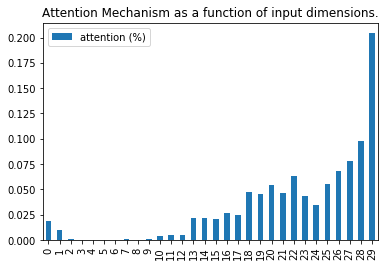

In [59]:
layer_name ="permute_20"
show_attention_weight(model_atten_before_new42_30t,layer_name)

# prediction

In [54]:
# model_atten_before_new42_20t,test_data_new42_20t
#predict
test_x = test_data_new42_20t[0]
test_y = test_data_new42_20t[1]

prediction_new42_20t=[]
for indx in range(len(test_x)):
    item = test_x[indx]
    pred =model_atten_before_new42_20t.predict(np.array([item]))
    prediction_new42_20t.append(pred)
print(len(prediction_new42_20t))

#np.argwhere(test_y[indx] == 1)
predict_class_new42_20t =[]
test_class_new42_20t=[]
for i in range(len(prediction_new42_20t)):   
    test_class_new42_20t.append(np.argmax(test_y[i]== 1))
    predict_class_new42_20t.append(np.argmax(prediction_new42_20t[i], axis=1)[0])
print (len(test_class_new42_20t))
print (len(predict_class_new42_20t))

print("accuracy: ",accuracy_score(test_class_new42_20t, predict_class_new42_20t))
print("recall: ",recall_score(test_class_new42_20t, predict_class_new42_20t,average='macro')) #[None, 'micro', 'macro', 'weighted']
print("precision: ",precision_score(test_class_new42_20t, predict_class_new42_20t,average='macro'))

43085
43085
43085
accuracy:  0.4078913775095741
recall:  0.49170585465304056
precision:  0.5577034816430161


## top 3 the most prevalent target diseases prediction model


In [83]:
#top 3 : Bacterial Infection, Severe Pain, Corticosteroid- responsive dermatoses
print(disease_dict["Bacterial infection"],disease_dict["Severe pain"],disease_dict["Corticosteroid-responsive dermatoses"])

145 276 262


In [84]:
print(top50_dict[145],top50_dict[276],top50_dict[262])

7 6 5


192526 22880
45760 45760
len of train data:  36608
len of train data:  9152


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_23 (Permute)            (None, 294, 20)      0           input_12[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 294, 20)      0           permute_23[0][0]                 
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 294, 20)      420         reshape_12[0][0]                 
__________________________________________________________________________________________________
permute_24

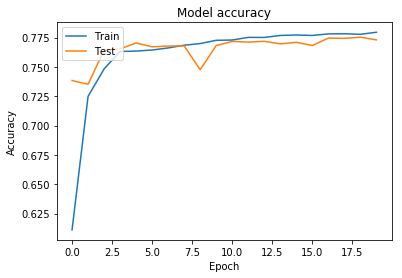

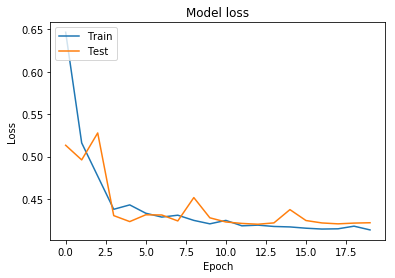

Training Time :  908.2300047874451


In [86]:
import time

target=7
model_num = 5
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4BI,test_data_for4BI = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4BI.save('binary_model4BI.h5')

192526 22880
45760 45760
len of train data:  36608
len of train data:  9152


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_25 (Permute)            (None, 294, 20)      0           input_13[0][0]                   
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 294, 20)      0           permute_25[0][0]                 
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 294, 20)      420         reshape_13[0][0]                 
__________________________________________________________________________________________________
permute_26

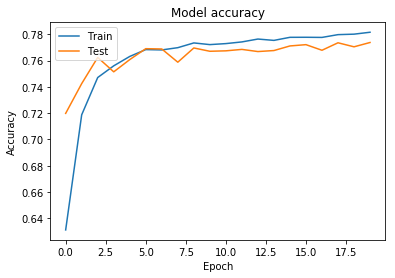

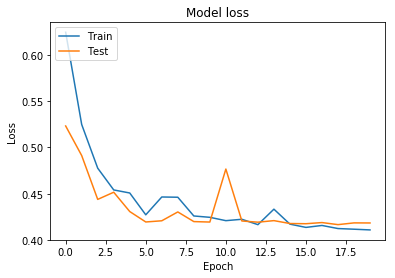

Training Time :  872.9731810092926


In [87]:
import time

target=7 #BI
model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4BI2,test_data_for4BI2 = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4BI2.save('binary_model4BI2.h5')

198519 15823
31646 31646
len of train data:  25317
len of train data:  6329


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_33 (Permute)            (None, 294, 20)      0           input_17[0][0]                   
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 294, 20)      0           permute_33[0][0]                 
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 294, 20)      420         reshape_17[0][0]                 
__________________________________________________________________________________________________
permute_34

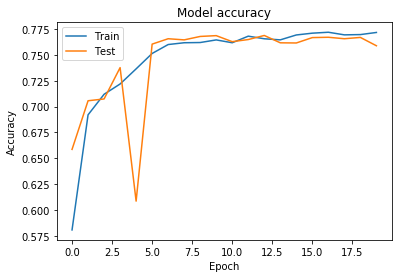

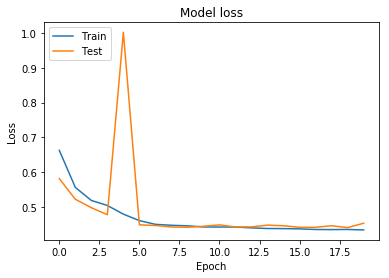

Training Time :  602.0943689346313


In [91]:
import time

target=6
model_num = 5
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4SP,test_data4SP = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4SP.save('binary_model4SP.h5')

198519 15823
31646 31646
len of train data:  25317
len of train data:  6329


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_27 (Permute)            (None, 294, 20)      0           input_14[0][0]                   
__________________________________________________________________________________________________
reshape_14 (Reshape)            (None, 294, 20)      0           permute_27[0][0]                 
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 294, 20)      420         reshape_14[0][0]                 
__________________________________________________________________________________________________
permute_28

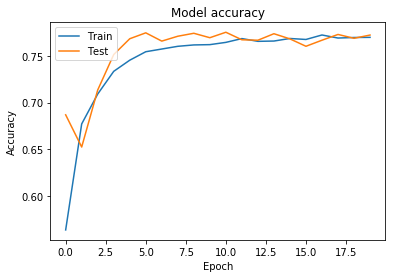

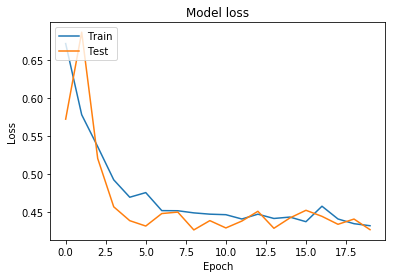

Training Time :  598.1275489330292


In [88]:
import time

target=6
model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4SP2,test_data4SP2 = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4SP2.save('binary_model4SP2.h5')

197644 17777
35554 35554
len of train data:  28443
len of train data:  7111


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_31 (Permute)            (None, 294, 20)      0           input_16[0][0]                   
__________________________________________________________________________________________________
reshape_16 (Reshape)            (None, 294, 20)      0           permute_31[0][0]                 
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 294, 20)      420         reshape_16[0][0]                 
__________________________________________________________________________________________________
permute_32

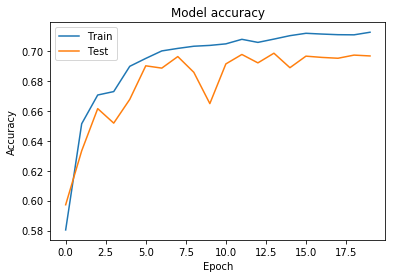

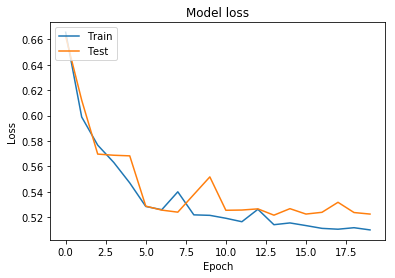

Training Time :  692.7475869655609


In [90]:
import time

target=5
model_num = 5
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4CRD,test_data4CRD = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4CRD.save('binary_model4CRD.h5')

197644 17777
35554 35554
len of train data:  28443
len of train data:  7111


/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20, 294)      0                                            
__________________________________________________________________________________________________
permute_29 (Permute)            (None, 294, 20)      0           input_15[0][0]                   
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 294, 20)      0           permute_29[0][0]                 
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 294, 20)      420         reshape_15[0][0]                 
__________________________________________________________________________________________________
permute_30

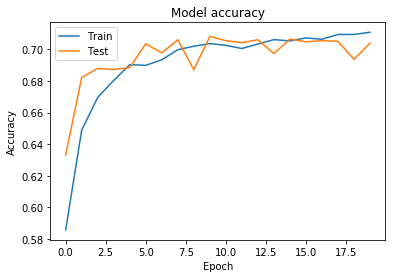

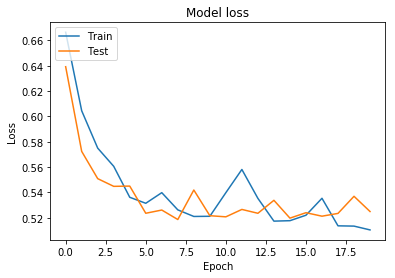

Training Time :  645.1534190177917


In [89]:
import time

target=5
model_num = 6
test_size = 0.2

EPOCHS = 20
BATCH_SIZE = 128
#LIMIT_RATE = 0.95

start = time.time()
binary_model4CRD2,test_data4CRD2 = train_model_binary(model_num,test_size,target)
print("Training Time : ", time.time() - start)

binary_model4CRD2.save('binary_model4CRD.h5')

## prediction & metrics

In [30]:
# prediction function 

def predict_binary(testdata,model):
    #predict
    test_x = testdata[0]
    test_y = testdata[1]

    pred_prob=[]
    pred_class=[]

    for indx in range(len(test_x)):
        item = test_x[indx]
        pred =model.predict(np.array([item]))
        pred_prob.append(pred)
    print(len(pred_prob))

    # trans to class
    for i in pred_prob:
        if i >0.5:
            pred_class.append(1)
        else:
            pred_class.append(0)

    print(len(pred_class))
    return test_y,pred_class

#check the accuary


def get_ac_se_sp(ylabe,ypred):
    cm = confusion_matrix(ylabe,ypred,labels=None, sample_weight=None)
    tp = cm[0][0]
    fp = cm[1][0]
    fn = cm[0][1]
    tn = cm[1][1]

    accuracy = (tp+tn)/(tp+fp+fn+tn)*100
    sensitive = tp/(tp+fn)* 100
    Specificity = tn /(tn+fp) * 100
    print(cm)
    print("accuracy",accuracy,"sensitive: ",sensitive,"Specificity: ",Specificity)
    return


In [92]:
test4bi,pred4bi=predict_binary(test_data_for4BI,binary_model4BI)
get_ac_se_sp(test4bi,pred4bi)

test4bi2,pred4bi2=predict_binary(test_data_for4BI2,binary_model4BI2)
get_ac_se_sp(test4bi2,pred4bi2)

9152
9152
[[2999 1559]
 [ 561 4033]]
accuracy 76.83566433566433 sensitive:  65.79640193067135 Specificity:  87.78841967784065
9152
9152
[[2850 1640]
 [ 339 4323]]
accuracy 78.37631118881119 sensitive:  63.474387527839646 Specificity:  92.72844272844273


In [93]:
test4SP,pred4SP=predict_binary(test_data4SP,binary_model4SP)
get_ac_se_sp(test4SP,pred4SP)

test4SP2,pred4SP2=predict_binary(test_data4SP2,binary_model4SP2)
get_ac_se_sp(test4SP2,pred4SP2)

6329
6329
[[2133  995]
 [ 558 2643]]
accuracy 75.46215831884973 sensitive:  68.19053708439897 Specificity:  82.56794751640113
6329
6329
[[2160 1008]
 [ 573 2588]]
accuracy 75.0197503555064 sensitive:  68.18181818181817 Specificity:  81.87282505536223


In [94]:
test4CRD,pred4CRD=predict_binary(test_data4CRD,binary_model4CRD)
get_ac_se_sp(test4CRD,pred4CRD)

test4CRD2,pred4CRD2=predict_binary(test_data4CRD2,binary_model4CRD2)
get_ac_se_sp(test4CRD2,pred4CRD2)

7111
7111
[[1964 1595]
 [ 611 2941]]
accuracy 68.9776402756293 sensitive:  55.184040460803594 Specificity:  82.79842342342343
7111
7111
[[2105 1455]
 [ 730 2821]]
accuracy 69.27295738995922 sensitive:  59.12921348314607 Specificity:  79.4424105885666
